# Recipe Recommender Tool for Food Waste Reduction

Project By: Margaret Boland

This project aims to help reduce food waste on the consumer level by using collaborative filtering methods to create a recipe recommender that allows users to input food items in their fridge that are about to expire and then outputs recipe recommendations based on the user's past recipe ratings that include that ingredient.

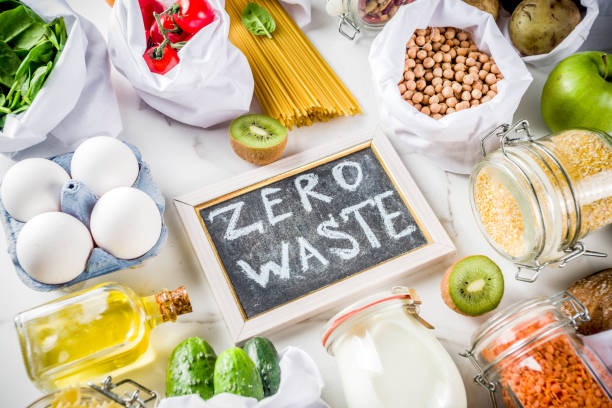

_source: https://www.istockphoto.com/photos/food-waste-reduction_

## The Detrimental Effects of Food Waste

> Food waste - or food that is fit for consumption but disposed of - is a major problem in the US with up to 40% of food produced going uneaten, according to [Harvard’s School of Public Health](https://www.hsph.harvard.edu/nutritionsource/sustainability/food-waste/). Further, there are environmental effects of food waste. 95% of uneaten food goes to landfills. This decomposing food produces methane gasses, which is a significant contributor to global warming and subsequently adds to climate change.  The reduction of food waste could not only lead to savings costs for consumers, but also help curb contributors to climate change. 

>While much of food waste comes at the macro level (transporation networks, restaurants and organizations), households prove to waste substantial food - 1/3 of food obtained by households is wasted, according to [The Economist](https://www.economist.com/the-economist-explains/2016/08/28/why-wasting-food-is-bad-for-the-planet). By creating a food recommendation tool that takes into account what already exists in the consumer's fridge as well as that consumer's preferences, the hope is that recipes will not only be relevant to the consumer, but also encourage consumers to use those ingredients rather than get rid of them. 

## Data Understanding 
>Data for this project came from Kaggle and looks at consumer [reviews and ratings](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) of recipes from Food.com. For the purposes of this project, I used the RAW_recipes.csv and RAW_interactions.csv files to build new datasets. The original files are too large to add to Github and thus instructions on how to replicate my process can be found in the [READMe](https://github.com/mboland23/Recipe-Recommender/blob/main/README.md). 

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML
from surprise.model_selection.split import train_test_split as surprise_train_test_split
from surprise.model_selection import GridSearchCV, cross_validate

%matplotlib inline

## I. User Review Data

>User data is the cornerstone of recommendation systems and collaborative filtering. In collaborative filtering that takes a user-to-user approach like I do here, a user's preference is determined both by its past preferences — in this case that user's recipe ratings — and the preferences of similar users. The user review data in this project is fairly straightforward and includes unique user_id, recipe_id (this is the key between user review data and the recipe data),  date (we do not use this column), rating (an explicit rating from 1-5), and review (text about the review). 

In [2]:
#Read in the user_reviews data file
user_reviews_df = pd.read_csv("./Data/user_reviews.csv", index_col=[0])

In [3]:
# Looking at the data from the 
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598158 entries, 8 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    598158 non-null  int64 
 1   recipe_id  598158 non-null  int64 
 2   date       598158 non-null  object
 3   rating     598158 non-null  int64 
 4   review     598154 non-null  object
dtypes: int64(3), object(2)
memory usage: 27.4+ MB


>We have 598,158 user ratings. There are four missing review column. Because this is such a small amount, we can drop these columns in case we want to later use review comments in some form. 

In [4]:
#Drop 4 missing reviews
user_reviews_df.dropna(inplace=True)

In [5]:
#Check no missing values
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598154 entries, 8 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    598154 non-null  int64 
 1   recipe_id  598154 non-null  int64 
 2   date       598154 non-null  object
 3   rating     598154 non-null  int64 
 4   review     598154 non-null  object
dtypes: int64(3), object(2)
memory usage: 27.4+ MB


In [6]:
#Turn user_id, recipe_id, review to string
user_reviews_df["review"] = user_reviews_df["review"].astype(str)
user_reviews_df["user_id"] = user_reviews_df["user_id"].astype(str)
user_reviews_df["recipe_id"] = user_reviews_df["recipe_id"].astype(str)

In [7]:
#Turn rating into a float
user_reviews_df["rating"] = user_reviews_df["rating"].astype(float)

In [8]:
#Check that the changes worked
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598154 entries, 8 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    598154 non-null  object 
 1   recipe_id  598154 non-null  object 
 2   date       598154 non-null  object 
 3   rating     598154 non-null  float64
 4   review     598154 non-null  object 
dtypes: float64(1), object(4)
memory usage: 27.4+ MB


### Visualizing Ratings Data

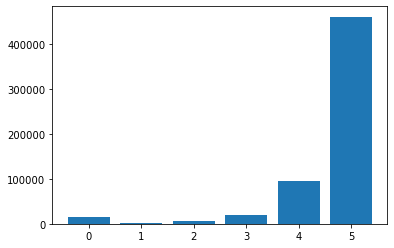

In [9]:
#Creating a bar chart to see the distribution of ratings
rating_count = user_reviews_df["rating"].value_counts().sort_index(ascending=False)

plt.bar(rating_count.index, rating_count.values);

In [10]:
rating_count

5.0    460937
4.0     95038
3.0     19168
2.0      5548
1.0      2770
0.0     14693
Name: rating, dtype: int64

>77% of our new dataset includes 5 star reviews, which heavily skews the data and will affect the recommendation portal.

>We also notice that 2.4% of our dataset includes a 0 rating. It would be important to see if these are actually 0s or if they are imputed value for missing ratings.

### Handling the Zero Rating 

In [11]:
#Looking at the 0 ratings to see if they are actually 0s or missing ratings
user_reviews_df.loc[user_reviews_df["rating"] == 0]

,user_id,recipe_id,date,rating,review
12,468945,134728,2008-02-20,0.0,Made my own buttermilk w/ vinegar and milk. U...
23,681408,225241,2008-03-14,0.0,This is a very good recipe. We also want to c...
56,980899,79222,2010-10-18,0.0,"I used half cream and half 1% milk, added anot..."
539,93911,306919,2010-07-08,0.0,I haven't tried this recipe so I'm not rating ...
642,921361,232042,2014-10-03,0.0,Tasted great and was super easy to make. Thank...
...,...,...,...,...,...
1131752,194886,99731,2013-01-24,0.0,"This is a great recipe, I thought I had review..."
1131780,113509,130019,2012-04-20,0.0,Hubby and I thought this was good. Neither of ...
1131953,374506,39724,2008-03-19,0.0,Great!!! After the turkey was done I browned t...
1132016,329378,39902,2006-10-19,0.0,"While the recipe calls for 3 cups of cheese, t..."


>It looks like the 0s are both a mix of positive and negative (or neutral reviews). While it is a small subset of our dataset it could be important to include these reviews considering the skew of our data. We could impute ratings based on the language used in the "review" column using NLP preprocessing and KNN Imputer, but this could lead to data leakage concerns and long processing times. In this case we will just drop these data points.

In [12]:
#Dropping rating that are 0 
#df.drop(df.loc[df['line_race']==0].index, inplace=True)
user_reviews_df.drop(user_reviews_df.loc[user_reviews_df["rating"]==0].index, inplace=True)

In [13]:
#Check thaat the 0s are gone
user_reviews_df["rating"].value_counts()

5.0    460937
4.0     95038
3.0     19168
2.0      5548
1.0      2770
Name: rating, dtype: int64

In [14]:
#Need to recheck that our recipes all have five ratings
user_reviews_df["recipe_id"].value_counts()

27208     1009
89204      979
32204      826
39087      825
69173      740
          ... 
39185        1
327682       1
491603       1
81157        1
256422       1
Name: recipe_id, Length: 53127, dtype: int64

In [15]:
# Number of recipes in our data frame
len(user_reviews_df["recipe_id"].value_counts())

53127

In [16]:
# Creating a list of recipe_review_counts for each recipe
# Remove recipes with less than 5 review counts

recipe_review_counts = user_reviews_df["recipe_id"].value_counts()

user_reviews_df = user_reviews_df[user_reviews_df["recipe_id"].isin(recipe_review_counts[recipe_review_counts >= 5].index)]

# Check that recipes with under 5 reviews were removed

len(user_reviews_df["recipe_id"].value_counts())


40527

In [17]:
# See what percentage of our recipes were dropped 
40527/53127

0.7628324580721667

In [18]:
# Checking the amount of reviews per user. 
# For recommendation modeling we need at least 5 reviews per reader. 

user_reviews_df["user_id"].value_counts()

37449         2789
383346        2396
424680        2145
128473        2024
89831         1893
              ... 
1591083          1
2001993143       1
2000216822       1
916602           1
2001522017       1
Name: user_id, Length: 18943, dtype: int64

In [19]:
# Create a list review counts for each user 
# Keep only those with more than 5 in the dataframe 
review_counts = user_reviews_df["user_id"].value_counts()
user_reviews_df = user_reviews_df[user_reviews_df["user_id"].isin(review_counts[review_counts >= 5].index)]

# Check that users with under 5 reviews were removed
len(user_reviews_df["user_id"].value_counts())

17096

In [20]:
#See what percentage of our users are left in our data set
17096/18943

0.9024969645779444

>We lost a fair bit more of our data - about 25% of our recipes - and 10% of our users, but now we make sure we have users with at least five reviews. And the user data is now ready for Surprise. 

In [21]:
#Save off as a csv file
#user_reviews_df.to_csv("./Data/user_reviews_no_zero.csv")

### Exploration of Final User Reviews Dataset 

In [22]:
user_reviews_df["user_id"].value_counts()

37449      2789
383346     2396
424680     2145
128473     2024
89831      1893
           ... 
55705         5
216536        5
2384828       5
630190        5
266522        5
Name: user_id, Length: 17096, dtype: int64

In [23]:
user_reviews_df["recipe_id"].value_counts()

27208     990
89204     959
39087     806
32204     806
69173     728
         ... 
86185       3
322417      3
475454      3
195395      3
179904      3
Name: recipe_id, Length: 40526, dtype: int64

In [24]:
user_reviews_df["rating"].value_counts()

5.0    426151
4.0     86486
3.0     17360
2.0      4952
1.0      2318
Name: rating, dtype: int64

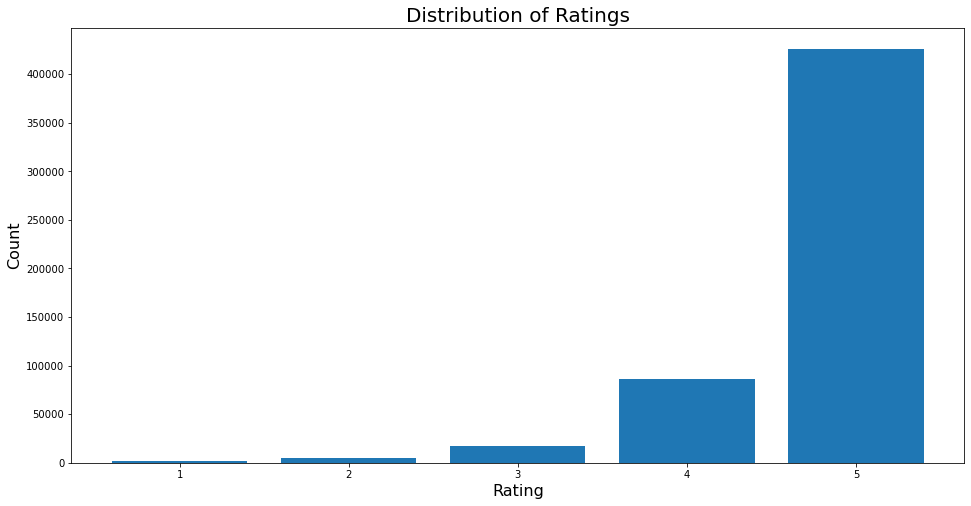

In [25]:
data = 426151, 86486, 17360, 4952, 2318
ratings = 5, 4, 3, 2, 1

fig, ax = plt.subplots(figsize=(16, 8))
plt.bar(ratings, data,  align='center', label=data, color="#1f77b4")
plt.ylabel("Count", fontsize=16)
plt.xlabel("Rating", fontsize=16),
plt.title("Distribution of Ratings", fontsize=20);
#plt.savefig("./Images/rating_dist")

>Our final user data set with recipe reviews has 537,267 reviews on 40,526 recipes from 17,096 reviewers/users.  

## II. Recipe Data  

>The recipe data - or metadata - contains all of the information regarding the recipes reviewed in the user_reviews dataset. This recipe data is used in the collaborative filtering process to help with subfiltering recommended recipes. 

>Like the original data file for the user_reviews, the recipe data file was too large to upload to GitHub. To find instructions on how to access the RAV_recipes.csv file please consult the [READMe](https://github.com/mboland23/Recipe-Recommender/blob/main/README.md). 

>The recipe data underwent substantial feature engineering - creating new nuitrition columns:
> - calories (#)
> - total fat (PDV)
> - sugar (PDV)
> - sodium (PDV)
> - protein (PDV)
> - saturated fat (PDV)
> - Carbohydrates(PDV)

>It also breaks out the ingredients column, which is originally a string of ingredients into a list of ingredients.

>Finally, I created a subcategorization function that labeled recipes on 8 different food types that would allow users to subset based on food type in the recommendation tool. The last three subcategorizations are taken from the new nuitrition columns. The recipe type subcategorizations are as follows (note: recipes can fall in multiple categories and all recipes fall under the any subcategorization): 
> - any (no subcategorization)
> - vegetarian
> - not vegetarian
> - beverage
> - dessert
> - low carb
> - low cal
> - sugar free

>For a detailed look at the manipulation of the recipe/meta data please refer to the meta_data_workbook_2. The rest of this notebook uses the final csv file called "recipes_subcat_cleaned 2.csv" from this workbook. 

## III. Modeling Using Surprise

In [26]:
#user_reviews_df = pd.read_csv("./Data/user_reviews_no_zero.csv", index_col=[0])

In [27]:
user_reviews_df[["user_id", "recipe_id"]] = user_reviews_df[["user_id", "recipe_id"]].astype(str)
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537267 entries, 31 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    537267 non-null  object 
 1   recipe_id  537267 non-null  object 
 2   date       537267 non-null  object 
 3   rating     537267 non-null  float64
 4   review     537267 non-null  object 
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


###  Modeling Setup

In [28]:
# Set up data frame for Surprise using user_id, recipe_id, and rating
rating_surprise_df = user_reviews_df[["user_id", "recipe_id", "rating"]]
len(rating_surprise_df["recipe_id"].value_counts())

40526

In [29]:
rating_surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537267 entries, 31 to 1132357
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    537267 non-null  object 
 1   recipe_id  537267 non-null  object 
 2   rating     537267 non-null  float64
dtypes: float64(1), object(2)
memory usage: 16.4+ MB


In [30]:
len(rating_surprise_df["user_id"].value_counts())

17096

In [31]:
reader = Reader(rating_scale=(1,5))
surprise_data = Dataset.load_from_df(rating_surprise_df, reader)

In [32]:
surprise_data

In [33]:
#Set up train_test_split 
trainset, testset = surprise_train_test_split(surprise_data, test_size= 0.2, random_state=42)

### Dummy Model: NormalPredictor( )

In [34]:
#Instantiate the NormalPredictor() from Surprise
baseline = NormalPredictor()

#Fit on the trainset
baseline.fit(trainset)

#Predict ratings on testset
predictions = baseline.test(testset)

#Scoring based on RMSE
baseline = accuracy.rmse(predictions)

RMSE: 0.7609


>Our Dummy Model has a Root Mean Squared Error (RMSE) of 0.76 meaning that our dummy model predicts ratings that are on average 0.76 points off of the "true" ratings of recipes. This is pretty decent but let's see if other models can drive down that score. 

### BaselineOnly ( ) Model

In [35]:
# Instantiate BaselineOnly() from Surprise
baseline_only = BaselineOnly()

# Fit on the trainset
baseline_only.fit(trainset)

# Predict ratings on the testset
predictions = baseline_only.test(testset)

# Scoring based on RMSE
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.5602


>The Baseline Only model has an RMSE of 0.56 meaning that our baseline only model predicts ratings that are on average 0.56 points off of the "true" ratings of the recipes. This is an improvement over our Dummy Model but can be improved upon using more complicated models. 

### SVD Model

In [36]:
# Instantiate SVD Model with default hyperparameters
svd = SVD(random_state=42)

# Fit on the trainset
svd.fit(trainset)

# Predict ratings on the testset
predictions = svd.test(testset)

# Scoring based on RMSE
SVD_default = accuracy.rmse(predictions)

RMSE: 0.5654


>The SVD Model with default hyperparameters has an RMSE of 0.57 meaning that our model predicts ratings that are on average 0.57 points off of the true ratings of the recipes. While this is slightly worse performing than our Baseline Only model, we can adjust hyperparameters to see if it performs better. We will perform a gridsearch to see the best performing RMSE. 

### Gridsearch with SVD Model 

>Becuase it produced lower RMSEs compared to other models, I performed three SVD Model gridsearches. For the sake of this notebook, I will show the gridsearch that produced the best overall results (i.e. the lowest RMSE) out of all of the surprise models. For more on the models that were run, as well as the SVD gridsearches, please look at the modeling notebook. 

In [37]:
# Gridsearch using lower n_factors
SVD_params_3 = {'n_factors':[3,5,10],
             'n_epochs':[25, 30, 35],
            'lr_all': [.0025]}

# Set up the Gridsearch using the parameters above
#svd_gridsearch_3 = GridSearchCV(SVD, param_grid = SVD_params_3, measures = ["rmse", "mae"], cv=5)

# Fit on the full data
#svd_gridsearch_3.fit(surprise_data)

# Pull out best_params from the gridsearch based on RMSE
#svd_gridsearch_3.best_params["rmse"]

In [38]:
#Instantiate on SVD model
svd_model_3 = SVD(n_factors = 3 ,  n_epochs= 35  , lr_all = .0025, random_state=42)

#Fit on trainset
svd_model_3.fit(trainset)

# Predict for testset
predictions = svd_model_3.test(testset)

#RMSE 
svd_model_3 = accuracy.rmse(predictions)

RMSE: 0.5593


>The SVD Model with best parameters from the gridsearch has. an RMSE of 0.559 meaning that our model predicts ratings that are on average 0.56 points off of the true ratings of the recipes. This is the best performing model so far, but only slightly beter than our last SVD model. We could drop the n_factors since again it is at the lower bounds of the settings, but the difference in RMSE may be minimal with the computation power tradeoff. 

### NMF Model

>I also tried Non-Negative Matrix Factorilization (NMF) models. These models are very similar to SVD models, so we expect them to perform similaraly. 

In [41]:
# Instantiate SVD Model with default hyperparameters
nmf = NMF(random_state=42)

# Fit on the trainset
nmf.fit(trainset)

# Predict ratings on the testset
predictions = nmf.test(testset)

# Scoring based on RMSE
NMF_default = accuracy.rmse(predictions)

RMSE: 0.6948


>Our RMSE with the defaul parameters for the NMF model is 0.69 meaning that the model predicts ratings that are on average 0.69 points off of the real ratings. This is so far our worst performing model since the baseline model. Because we have other SVD models that performed better we will not grid search the parameters on this model and look at Surprise's other KNN models. 

### KNN Basic Model

>The first of the KNN models I tried was the KNN Basic model from Surprise. I used user_based = True so that the algorithm predicts ratings based on cosine distance from like users rather than like items (recipes). 

In [59]:
sim_cos = ({'name':'cosine', 'user_based':True})
knn_basic = KNNBasic(sim_options=sim_cos, random_state=42)

# Fit on the trainset
knn_basic.fit(trainset)

# Predict ratings
predictions = knn_basic.test(testset)

# RMSE
#knn_basic = accuracy.rmse[predictions]
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6448
0.6447560486634945


>This model performed better than our NMF default parameter model but worse than our SVD, so we will not explore it further. For other KNN based models and coclustering, please take a look at the modeling notebook. 

### Model Performance

> I ran many Surprise models, which you can look at the modeling notebook for reference on specifics. Our best model, the one with the lowest RMSE came from an SVD gridsearch. I will use this as our best model moving forward. Below is an image of the performance of the multiple models. 

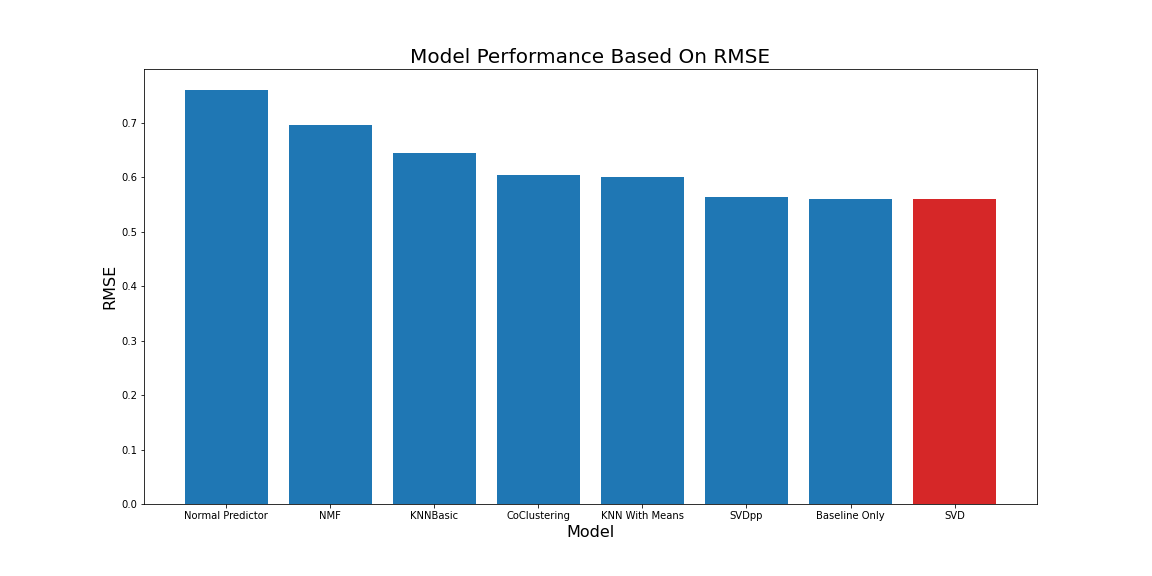

## IV. Recommendation Function

In [42]:
#user_ratings_df = pd.read_csv("./Data/user_reviews_no_zero.csv", index_col=[0])

In [43]:
recipes_df = pd.read_csv("./Data/recipes_subcat_cleaned 2.csv", index_col=[0])

In [44]:
#Clean the ingredients column so each row is a list of strings
recipes_df["ingredients"] = recipes_df["ingredients"].str.replace("'", "")
recipes_df["ingredients"] = recipes_df["ingredients"].str.strip("[")
recipes_df["ingredients"] = recipes_df["ingredients"].str.strip("]")
recipes_df["ingredients"] = recipes_df["ingredients"].str.split(", ")

In [45]:
#Clean the recipe_type column so each row is a list of strings
recipes_df["recipe_type"] = recipes_df["recipe_type"].str.replace("'", "")
recipes_df["recipe_type"] = recipes_df["recipe_type"].str.strip("[")
recipes_df["recipe_type"] = recipes_df["recipe_type"].str.strip("]")
recipes_df["recipe_type"] = recipes_df["recipe_type"].str.split(", ")

### Setting up Surprise with Best Model

In [46]:
user_reviews_df[["user_id", "recipe_id"]] = user_reviews_df[["user_id", "recipe_id"]].astype(int)

In [47]:
rating_surprise_df = user_reviews_df[["user_id", "recipe_id", "rating"]]

In [48]:
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(rating_surprise_df, reader)

In [49]:
trainset_full = surprise_data.build_full_trainset()

In [50]:
best_model = SVD(n_factors = 3,  n_epochs= 35, lr_all = .0025)
best_model.fit(trainset_full)

### Creating the Recommender Function

In [51]:
## Subset data frame to show reviewers the products they have rated 

prior_ratings_df = pd.DataFrame(user_reviews_df.set_index("user_id"))
prior_ratings_df.drop(columns=["date", "rating", "review"], inplace=True)
prior_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537267 entries, 56680 to 1122988
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   recipe_id  537267 non-null  int64
dtypes: int64(1)
memory usage: 8.2 MB


In [52]:
# Create a new column that converts the list of ingredients to a set to improve efficiencies in the function
recipes_df["set_ingredients"] = recipes_df["ingredients"].apply(lambda x: set(x))

In [53]:
def recommended_recipes():
    #set up to not truncate display
    pd.set_option("display.max_colwidth", None)
    
    # Set up user inputs 
    user = int(input("user_id: "))
    ingredient_request = input("What ingredients do you need to use?  ")
    sub_cat_request = input("Recipe type? ")
    num = int(input("How many recipes would you like to see? "))
    
    # Set up dictionary to account for variations of ingredients 
    ingredient_variations = {"chicken" : ["chicken", "chicken breast"],
                        "tomato": ["tomato", "diced tomato", "crushed tomato", "chopped tomato", "heirloom tomato"],
                        "onion": ["onion","yellow onion", "red onion", "sweet onion", "vidailia onion", "chopped onion", "diced onion"],
                        "garlic": ["garlic", "peeled garlic", "crushed garlic", "garlic clove", "garlic cloves", "head of garlic", "minced garlic"],
                        "lettuce": ["lettuce", "lettuce leaf", "romaine lettuce", "red leaf lettuce", "garden lettuce"],
                        "shallot": ["shallot", "diced shallot", "quartered shallot", "chopped shallot"],
                        "potato": ["potato", "diced potato", "quartered potato", "mashed potato", "red potato", "yellow potato", "yukon gold potato", "gold potato"],
                        "shrimp": ["shrimp","raw shrimp", "deveined shrimp", "peeled shrimp"],
                        "celery": ["celery", "rib of celery", "chopped celery"],
                        "bell pepper": ["bell pepper", "green bell pepper", "red bell pepper", "diced pepper", "chopped pepper"]
                        }
    
    
    # Set up a list for each user of recipes alredy reviewed 
    reviewed = list(prior_ratings_df.loc[user,"recipe_id"])
    
    # Create a data frame that does not include recipes already reviewed 
    not_reviewed = recipes_df.copy()
    not_reviewed = not_reviewed[not_reviewed.recipe_id.isin(reviewed) == False]
    not_reviewed.reset_index(inplace=True)
            
            
    # Iterate through each row using a for loop to create list that contains recipe_ids tht match ingredient and type
    # Create the empty list of recipes
    recipes_w_ingredient_subcat = []
    #Set ingredient_request equal to the values in dict if ingredient_request is a key, if not set equal to itself
    #ingredient_request = ingredient_variations.get(ingredient_request, str(ingredient_request))
    #ingredient_request = set(ingredient_request)
    ingredient_request = ingredient_variations.get(ingredient_request, set([ingredient_request]))
    if type(ingredient_request) != set: 
        ingredient_request = set(ingredient_request)
    #loop through recipes finding where ingredient_request matches with set_ingredients and recipe_type
    for index, row in recipes_df.iterrows():
        if ingredient_request.intersection(row["set_ingredients"]) and sub_cat_request in row["recipe_type"]:
            recipes_w_ingredient_subcat.append(row["recipe_id"])
    
    # Create a copy of not_reviewed df that only contains recipe_ids that are in the recipe_w_ingredient_subcat list
    ingredient_recipes = not_reviewed.copy()
    ingredient_recipes = ingredient_recipes[ingredient_recipes.recipe_id.isin(recipes_w_ingredient_subcat)]
    ingredient_recipes.reset_index(inplace=True)
    

    # Create predicted rating for each recipe_id using the best_model, sort by highest rating
    ingredient_recipes["predicted_rating"] = ingredient_recipes["recipe_id"].apply(lambda x: best_model.predict(int(user), x).est)
    ingredient_recipes.sort_values(by="predicted_rating", ascending=False, inplace=True)
    ingredient_recipes = ingredient_recipes[["name", "minutes", "ingredients", "recipe_type", "predicted_rating"]] 
    
    return ingredient_recipes.head(num)
    

>Now let's test out the function using the same user with a user_id = 462571 and see the different results for the ingredient tomato based on the recipe type. Note that the dictionary of ingredient_variations has worked as the results include recipes with chopped tomato, diced tomoato, etc. 

In [54]:
#user_id = 462571
#ingredient = tomato
#food_type = vegetarian
# num =4
recommended_recipes()

user_id: 462571
What ingredients do you need to use?  tomato
Recipe type? vegetarian
How many recipes would you like to see? 4


,name,minutes,ingredients,recipe_type,predicted_rating
285,three cheese enchiladas,40,"[monterey jack cheese, cheddar cheese, cream cheese, pace picante sauce, red bell pepper, green onion, cumin, flour tortillas, lettuce, chopped tomato]","[vegetarian, any]",4.530693
149,layered hummus dip,15,"[hummus, cumin, chopped tomato, garlic salt, cucumber, fresh ground pepper, feta cheese, kalamata olives, parsley]","[vegetarian, any, low cal, low carb]",4.502483
57,chili cheese omelette burritos,15,"[chili, cheddar cheese, eggs, water, salt and pepper, butter, flour tortillas, onion, diced tomato, sour cream, salsa]","[vegetarian, any, low carb]",4.482661
138,hummus and veggie wrap,5,"[tortillas, hummus, cucumber, diced tomato, bell pepper, shoestring carrots, red onions, alfalfa sprout, lettuce]","[vegetarian, any]",4.469189


In [55]:
#user_id = 462571
#ingredient = tomato
#food_type = not vegetarian
# num =4
recommended_recipes()

user_id: 462571
What ingredients do you need to use?  tomato
Recipe type? not vegetarian
How many recipes would you like to see? 4


,name,minutes,ingredients,recipe_type,predicted_rating
215,great white chili supposed to be by willie nelson,270,"[white beans, chicken broth, chicken base, onions, oil, garlic, diced green chilies, ground cumin, dried oregano leaves, cayenne pepper, cilantro, cooked chicken, sour cream, monterey jack cheese, green onion, chopped tomato]","[any, not vegetarian]",4.506803
152,dorito taco salad,20,"[ground beef, lettuce, chopped tomato, cheddar cheese, red onion, taco seasoning, ranch style beans, catalina dressing, doritos]","[any, not vegetarian]",4.506360
363,quesadillas for one or two,15,"[oil, flour tortillas, cheddar cheese, chopped tomato, green chili, guacamole, green onion, green bell pepper, black olives, sour cream, salsa, refried beans, chicken, turkey, ham, beef, crabmeat, shrimp]","[any, low cal, low carb, not vegetarian]",4.491740
438,steak or chicken fajitas,20,"[top sirloin steak, olive oil, lime juice, garlic clove, chili powder, cumin, hot pepper flakes, black pepper, salt, flour tortillas, onion, sweet peppers, salsa, sour cream, cheese, chopped tomato]","[any, low cal, low carb, not vegetarian]",4.491406


> We can also run the function with different recipe ingredients for this user and see how the recommendations change. Let's try with chicken and beef and allow the subcategory to be equal to "any" - meaning any recipe type is allowed. 

In [56]:
#user_id = 462571
#ingredient = chicken
#food_type = any
# num =4
recommended_recipes()

user_id: 462571
What ingredients do you need to use?  chicken
Recipe type? any
How many recipes would you like to see? 4


,name,minutes,ingredients,recipe_type,predicted_rating
399,chicken and cheese french bread pizza,30,"[butter, cheddar cheese, parmesan cheese, garlic, dried italian seasoning, french bread, chicken, salt, pepper, mozzarella cheese, red bell pepper, green onion]","[any, not vegetarian]",4.543074
976,couscous jambalaya,40,"[raw shrimp, chicken breast, creole seasoning, olive oil, andouille sausages, onion, green bell pepper, celery, garlic, italian plum tomato, bay leaves, worcestershire sauce, hot pepper sauce, chicken stock, salt, fresh ground black pepper, couscous, paprika, garlic powder, black pepper, onion powder, cayenne pepper, dried oregano leaves, dried leaf thyme]","[any, low cal, not vegetarian]",4.524227
96,autumn chicken salad,20,"[chicken, red seedless grapes, celery ribs, red delicious apple, pecan halves, mayonnaise, honey mustard, salt, pepper, lettuce leaf]","[any, low cal, low carb, not vegetarian]",4.520405
17,6 can chicken tortilla soup,11,"[whole kernel corn, chicken broth, chicken, black beans, rotel tomatoes, refried beans]","[any, not vegetarian]",4.504363


In [57]:
#user_id = 462571
#ingredient = beef
#food_type = any
# num =4
recommended_recipes()

user_id: 462571
What ingredients do you need to use?  beef
Recipe type? any
How many recipes would you like to see? 4


,name,minutes,ingredients,recipe_type,predicted_rating
88,beef ramen stir fry,20,"[beef, red bell pepper, green bell pepper, ramen noodles, snow peas, broccoli, teriyaki sauce, vegetable oil, garlic powder, ginger powder]","[any, low carb, not vegetarian]",4.505178
304,hash,20,"[potatoes, onion, beef, salt and pepper, vegetable oil, butter]","[any, not vegetarian]",4.501582
316,homemade stock,125,"[water, bay leaf, peppercorns, oregano, thyme, basil, dill, salt, onion, carrot, broccoli stem, spinach leaves, fresh parsley, celery, green beans, tomatoes, mushroom, garlic cloves, shallot, leek, turnip, chicken piece, beef]","[any, low cal, low carb, not vegetarian]",4.497117
458,quesadillas for one or two,15,"[oil, flour tortillas, cheddar cheese, chopped tomato, green chili, guacamole, green onion, green bell pepper, black olives, sour cream, salsa, refried beans, chicken, turkey, ham, beef, crabmeat, shrimp]","[any, low cal, low carb, not vegetarian]",4.491740


## V. Conclusion 

### Evaluation & Limitations

>The final recommendation system is able to predict ratings that are 0.56 points from true ratings, meaning it is fairly accurate in pulling recipes that the user would like to cook — a necessary element to encourage users to cook expiring food rather than waste the food. Further, the recommender app does not recommend recipes that the user has already reviewed — allowing the user to discover new recipes. It also prioritizes the best match (highest expected rating) recipes with the input ingredient for that user. This is especially important for future use. If the user does not like a recipe recommended, they may not come back to the app - running the risk of wasted food. Finally, the recommender system allows users to denote if they would like to make a certain type of meal. This is important for users that have meal limitations. 

>While the recommendation application helps encourage the reduction of food waste at the household level, it does have limitations. First, since 79% of our original data comprised of reviews with 5 point rating, the recommender system skews to higher predicted ratings. This means that the difference between .01 predicted points at the higher end could be more significant than at lower levels. To remedy, one could repredict ratings of the original dataset using NLP. Further, the system does not take into account indiscriminate raters - or users that rate all recipes the same. This makes it more difficult to discern these user's preferences and thus their recommendations may not be as accurate. To fix this issue, we could again repredict their ratings based on the language of their reviews or follow up with more specific feedback. Finally, the collaborative filtering approach only works for users that have already reviewed recipes - new users cannot recieve predictions. This cold start probem could be remedied by recommending the highest rated recipes with a given ingredient to that user and asking them to review. They then could be added to the collaborative filtering pipeline. 

>Overall, the application can help reduce food waste at the household level by allowing users to input ingredients that they currently have and delivering recipes that are relevant, matched to the user, and expected to be enjoyed. 

### Next Steps

> 1. Determine whether 5 ratings are unique to our dataset or common to recipe reviews in general. NLP could help standardize ratings and reduce some of the high end skew of our data. 
> 2. Parse out preferences of indiscriminate reviewers through NLP. 
> 3. Solve cold start problem by creating a function that recommends the highest reviewed and rated recipes for a given ingredient. This would allow users to enter the pipeline for collaborative filtering. 